# Fast LISA Response Tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from fastlisaresponse import pyResponseTDI
from astropy import units as un

YRSID_SI = 31558149.763545603

## Gravitational wave signal

In [2]:
class GBLike:
    def __init__(self, response_model, sampling_frequency, Tobs, use_gpu=False):

        self.response_model = response_model
        if use_gpu:
            self.xp = xp
        else:
            self.xp = np
        self.n = int(Tobs * YRSID_SI / response_model.dt)
        self.Tobs = self.n * response_model.dt

        # add the buffer
        self.t_buffer = response_model.total_buffer * response_model.dt
        self.t = np.arange(
            response_model.t0_wave, response_model.tend_wave, response_model.dt
        )
        self.t_in = self.xp.asarray(
            self.t
        )  #  - self.t0_tdi  # sets quantities at beginning of tdi
        # TODO: should we keep this?

    def _get_h(self, A, f, fdot, iota, phi0, psi):
        cos2psi = self.xp.cos(2.0 * psi)
        sin2psi = self.xp.sin(2.0 * psi)
        cosiota = self.xp.cos(iota)

        fddot = 11.0 / 3.0 * fdot ** 2 / f

        # phi0 is phi(t = 0, which is shifted due to t_buffer)
        phase = (
            2
            * np.pi
            * (
                f * self.t_in
                + 1.0 / 2.0 * fdot * self.t_in ** 2
                + 1.0 / 6.0 * fddot * self.t_in ** 3
            )
            - phi0
        )

        hSp = -self.xp.cos(phase) * A * (1.0 + cosiota * cosiota)
        hSc = -self.xp.sin(phase) * 2.0 * A * cosiota

        hp = hSp * cos2psi - hSc * sin2psi
        hc = hSp * sin2psi + hSc * cos2psi

        return hp + 1j * hc

    def __call__(self, A, f, fdot, iota, phi0, psi, lam, beta):

        h = self._get_h(A, f, fdot, iota, phi0, psi)

        self.response_model.get_projections(h, lam, beta)
        tdi_out = self.response_model.get_tdi_delays()

        return tdi_out

## Build waveforms

### Setup classes

In [5]:

import matplotlib.pyplot as plt

# from ldc.waveform.waveform import HpHc
# from ldc.lisa.orbits import Orbits
# from ldc.lisa.projection import ProjectedStrain

use_gpu = False

num_pts_in = int(3.1557E+06)

sampling_frequency = 0.1
dt = 1 / sampling_frequency
T = (num_pts_in * dt) / YRSID_SI

order = 25

# add your file path here
orbit_file = "../esa-orbits.h5"

tdi_kwargs = dict(
    order=order,
    tdi="1st generation",
    tdi_chan="XYZ",  # or AET or AE
    num_pts=num_pts_in,
)

orbit_kwargs=dict(orbit_file=orbit_file)

response_model = pyResponseTDI(sampling_frequency,
        num_pts_in,
        orbit_kwargs,
        order=order,
        tdi="1st generation",
        tdi_orbit_kwargs={},
        tdi_chan="XYZ",
        t0=100.0,
        use_gpu=False,
)

gb = GBLike(response_model, sampling_frequency, T, use_gpu=use_gpu)

A = 1.084702251e-22
f = 2.35962078e-3
fdot = 1.47197271e-17
iota = 1.11820901
phi0 = 4.91128699
psi = 2.3290324

beta = 0.9805742971871619
lam = 5.22979888



### Run generator

In [6]:
chans = gb(A, f, fdot, iota, phi0, psi, lam, beta)

### Plot results

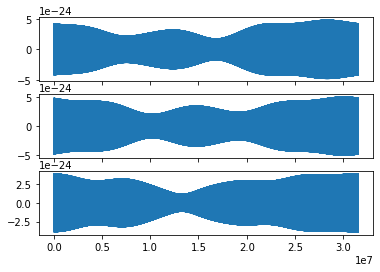

In [7]:
fig, ax = plt.subplots(3, 1, sharex=True)

for i in range(3):
    ax[i].plot(np.arange(len(chans[0])) * dt, chans[i])